## 3 ways of loading the model:

In [48]:
from tensorflow import saved_model
from tensorflow.keras import Sequential
import tensorflow_hub as hub
import numpy as np
from PIL import Image
from tensorflow import cast, convert_to_tensor, dtypes
import pandas as pd

In [70]:
eurosat_url = 'https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1'
eurosat_path = 'models/eurosat'
image_general_path = '../raw_data/raw_data/train-jpg/train-jpg'
input_shape = (256,256,3)
i = 0

### Preprocess function

In [77]:
def image_preparation(image, library = 'keras'):
    image_path = f"{image_general_path}/{image}"
    image = Image.open(image_path)
    image_array = np.asarray(image)/255
    image_rgb = image_array[:,:,:3]
    image_ready = np.expand_dims(image_rgb, axis = 0)
    
    if library == 'keras':
        return image_ready
    else:
        image_tensor = convert_to_tensor(image_ready)
        image_tensor_ready = cast(image_tensor, dtypes.float32)
        return image_tensor_ready
    
    
    

In [23]:
example_tf = image_preparation('train_0.jpg', 'tensorflow')
example_keras = image_preparation('train_0.jpg', 'keras')

### Keras model:

In [21]:
model_keras = Sequential([
    hub.KerasLayer(eurosat_url, input_shape = input_shape)
])

In [24]:
model_keras.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23566282  
                                                                 
Total params: 23,566,282
Trainable params: 0
Non-trainable params: 23,566,282
_________________________________________________________________


In [29]:
prediction_keras = model_keras.predict(example_keras)
prediction_keras.shape #This way loads everything but the 10 units prediction layer, I guess for fine tuning?

1/1 [==============================] - 0s 144ms/step


(1, 2048)

### As TensorFlow model:

In [39]:
tf_model_local = saved_model.load(eurosat_path, tags = 'train') #the tag argument seems to be required 
tf_model_url = hub.load(eurosat_url)

you can use both in the same way to get predictions, which looks the same:


In [40]:
prediction_tf_local = tf_model_local.signatures['default'](example_tf)
prediction_tf_url = tf_model_url.signatures['default'](example_tf)

In [41]:
prediction_tf_local

{'logits': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[-0.13254511, -2.4910147 , -1.7037553 ,  6.2905245 , -0.47602016,
         -0.6378507 ,  0.38392925, -3.8006241 ,  3.7254195 , -1.6774181 ]],
       dtype=float32)>,
 'default': <tf.Tensor: shape=(1, 2048), dtype=float32, numpy=
 array([[0.31462836, 0.28023988, 0.31792098, ..., 0.4024513 , 0.33039102,
         0.36210364]], dtype=float32)>,
 'block1': <tf.Tensor: shape=(1, 64, 64, 256), dtype=float32, numpy=
 array([[[[-11.391829  ,  -6.866455  ,  -3.8091915 , ..., -10.987638  ,
            -0.7746881 ,   0.04535919],
          [ -9.02926   ,  -6.2174597 ,  -1.231609  , ...,  -8.725872  ,
            -1.4235663 ,  -3.1380482 ],
          [ -8.877066  ,  -6.7193985 ,  -1.0681897 , ...,  -8.529654  ,
            -1.3200866 ,  -2.0158334 ],
          ...,
          [ -9.022892  ,  -6.6509304 ,  -2.8501978 , ...,  -9.738858  ,
            -2.1201391 ,  -2.0546317 ],
          [ -8.932536  ,  -6.0339327 ,  -2.9258344 , ...,

'logits' key is the prediction:

In [42]:
prediction_tf_local['logits']

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.13254511, -2.4910147 , -1.7037553 ,  6.2905245 , -0.47602016,
        -0.6378507 ,  0.38392925, -3.8006241 ,  3.7254195 , -1.6774181 ]],
      dtype=float32)>

In [64]:
prediction_tf_url['logits']

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 9.378589 ,  6.155255 ,  6.0221224, -1.481117 , -9.341475 ,
        -8.682676 , -6.26624  , -3.6459808, -9.793684 , 16.128918 ]],
      dtype=float32)>

In [47]:
#Why are they different- same model
prediction_tf_local['logits'] == prediction_tf_url['logits']

<tf.Tensor: shape=(1, 10), dtype=bool, numpy=
array([[False, False, False, False, False, False, False, False, False,
        False]])>

### Testing
seems very hard now to find the labels, let's see if we get consistent results with what we have:

In [60]:
df = pd.read_csv('../raw_data/train_clean_labels.csv')[['image_filename', 'label']]
sample = df.sample(5_000)

In [78]:
def url_predict(image_filename):
    i = 0
    print(f'image {image_filename} is in the process')
    image = image_preparation(image_filename, 'tensorflow')
    prediction = tf_model_url.signatures['default'](image)['logits']
    prediction_indice = np.argmax(prediction)
    print(f'{image_filename}: {prediction_indice}')
    i =+ 1
    return prediction_indice

In [79]:
sample['url_prediction'] = sample.image_filename.map(url_predict)

image train_24619.jpg is in the process
train_24619.jpg: 9
image train_17715.jpg is in the process
train_17715.jpg: 0
image train_35061.jpg is in the process
train_35061.jpg: 9
image train_24652.jpg is in the process
train_24652.jpg: 9
image train_4594.jpg is in the process
train_4594.jpg: 5
image train_31467.jpg is in the process
train_31467.jpg: 5
image train_10258.jpg is in the process
train_10258.jpg: 9
image train_4520.jpg is in the process
train_4520.jpg: 1
image train_28296.jpg is in the process
train_28296.jpg: 2
image train_15558.jpg is in the process
train_15558.jpg: 2
image train_13739.jpg is in the process
train_13739.jpg: 2
image train_9472.jpg is in the process
train_9472.jpg: 0
image train_40408.jpg is in the process
train_40408.jpg: 0
image train_25697.jpg is in the process
train_25697.jpg: 5
image train_1912.jpg is in the process
train_1912.jpg: 5
image train_21450.jpg is in the process
train_21450.jpg: 2
image train_13681.jpg is in the process
train_13681.jpg: 0
image

train_13264.jpg: 9
image train_21046.jpg is in the process
train_21046.jpg: 9
image train_23752.jpg is in the process
train_23752.jpg: 7
image train_8431.jpg is in the process
train_8431.jpg: 2
image train_37275.jpg is in the process
train_37275.jpg: 2
image train_4091.jpg is in the process
train_4091.jpg: 9
image train_6664.jpg is in the process
train_6664.jpg: 9
image train_22571.jpg is in the process
train_22571.jpg: 9
image train_20240.jpg is in the process
train_20240.jpg: 9
image train_17350.jpg is in the process
train_17350.jpg: 0
image train_18547.jpg is in the process
train_18547.jpg: 9
image train_37464.jpg is in the process
train_37464.jpg: 7
image train_11522.jpg is in the process
train_11522.jpg: 7
image train_24710.jpg is in the process
train_24710.jpg: 9
image train_12228.jpg is in the process
train_12228.jpg: 2
image train_35620.jpg is in the process
train_35620.jpg: 2
image train_19774.jpg is in the process
train_19774.jpg: 4
image train_33136.jpg is in the process
tra

train_29888.jpg: 4
image train_15148.jpg is in the process
train_15148.jpg: 9
image train_13241.jpg is in the process
train_13241.jpg: 9
image train_37027.jpg is in the process
train_37027.jpg: 9
image train_19747.jpg is in the process
train_19747.jpg: 9
image train_31320.jpg is in the process
train_31320.jpg: 5
image train_8082.jpg is in the process
train_8082.jpg: 2
image train_36085.jpg is in the process
train_36085.jpg: 9
image train_31145.jpg is in the process
train_31145.jpg: 2
image train_31370.jpg is in the process
train_31370.jpg: 7
image train_40237.jpg is in the process
train_40237.jpg: 9
image train_6910.jpg is in the process
train_6910.jpg: 2
image train_18712.jpg is in the process
train_18712.jpg: 9
image train_20214.jpg is in the process
train_20214.jpg: 0
image train_23263.jpg is in the process
train_23263.jpg: 9
image train_7647.jpg is in the process
train_7647.jpg: 0
image train_26444.jpg is in the process
train_26444.jpg: 2
image train_39790.jpg is in the process
tra

train_10087.jpg: 9
image train_27877.jpg is in the process
train_27877.jpg: 9
image train_7534.jpg is in the process
train_7534.jpg: 9
image train_25062.jpg is in the process
train_25062.jpg: 9
image train_7349.jpg is in the process
train_7349.jpg: 9
image train_23582.jpg is in the process
train_23582.jpg: 9
image train_3216.jpg is in the process
train_3216.jpg: 9
image train_1826.jpg is in the process
train_1826.jpg: 0
image train_20848.jpg is in the process
train_20848.jpg: 9
image train_29608.jpg is in the process
train_29608.jpg: 5
image train_35921.jpg is in the process
train_35921.jpg: 0
image train_20684.jpg is in the process
train_20684.jpg: 1
image train_8675.jpg is in the process
train_8675.jpg: 2
image train_12988.jpg is in the process
train_12988.jpg: 9
image train_33335.jpg is in the process
train_33335.jpg: 9
image train_8607.jpg is in the process
train_8607.jpg: 9
image train_6495.jpg is in the process
train_6495.jpg: 4
image train_4202.jpg is in the process
train_4202.j

train_23749.jpg: 4
image train_27544.jpg is in the process
train_27544.jpg: 9
image train_23814.jpg is in the process
train_23814.jpg: 0
image train_13185.jpg is in the process
train_13185.jpg: 9
image train_37569.jpg is in the process
train_37569.jpg: 9
image train_33404.jpg is in the process
train_33404.jpg: 2
image train_17151.jpg is in the process
train_17151.jpg: 9
image train_14390.jpg is in the process
train_14390.jpg: 9
image train_38793.jpg is in the process
train_38793.jpg: 0
image train_9938.jpg is in the process
train_9938.jpg: 9
image train_36211.jpg is in the process
train_36211.jpg: 2
image train_36568.jpg is in the process
train_36568.jpg: 0
image train_39471.jpg is in the process
train_39471.jpg: 9
image train_21096.jpg is in the process
train_21096.jpg: 3
image train_21386.jpg is in the process
train_21386.jpg: 0
image train_13708.jpg is in the process
train_13708.jpg: 9
image train_18238.jpg is in the process
train_18238.jpg: 9
image train_3147.jpg is in the process


train_29364.jpg: 2
image train_14410.jpg is in the process
train_14410.jpg: 9
image train_19547.jpg is in the process
train_19547.jpg: 5
image train_25884.jpg is in the process
train_25884.jpg: 8
image train_31253.jpg is in the process
train_31253.jpg: 9
image train_40188.jpg is in the process
train_40188.jpg: 9
image train_6327.jpg is in the process
train_6327.jpg: 8
image train_19669.jpg is in the process
train_19669.jpg: 9
image train_27636.jpg is in the process
train_27636.jpg: 2
image train_27279.jpg is in the process
train_27279.jpg: 9
image train_39855.jpg is in the process
train_39855.jpg: 7
image train_27546.jpg is in the process
train_27546.jpg: 2
image train_39399.jpg is in the process
train_39399.jpg: 4
image train_24091.jpg is in the process
train_24091.jpg: 2
image train_13030.jpg is in the process
train_13030.jpg: 4
image train_22131.jpg is in the process
train_22131.jpg: 0
image train_8918.jpg is in the process
train_8918.jpg: 9
image train_13623.jpg is in the process
t

train_22702.jpg: 4
image train_27413.jpg is in the process
train_27413.jpg: 0
image train_39491.jpg is in the process
train_39491.jpg: 9
image train_16308.jpg is in the process
train_16308.jpg: 2
image train_15908.jpg is in the process
train_15908.jpg: 2
image train_36459.jpg is in the process
train_36459.jpg: 2
image train_10630.jpg is in the process
train_10630.jpg: 9
image train_1472.jpg is in the process
train_1472.jpg: 9
image train_27373.jpg is in the process
train_27373.jpg: 9
image train_32543.jpg is in the process
train_32543.jpg: 9
image train_24726.jpg is in the process
train_24726.jpg: 7
image train_26291.jpg is in the process
train_26291.jpg: 9
image train_3785.jpg is in the process
train_3785.jpg: 9
image train_31632.jpg is in the process
train_31632.jpg: 9
image train_71.jpg is in the process
train_71.jpg: 9
image train_10690.jpg is in the process
train_10690.jpg: 9
image train_2915.jpg is in the process
train_2915.jpg: 9
image train_26731.jpg is in the process
train_267

train_31859.jpg: 2
image train_19064.jpg is in the process
train_19064.jpg: 9
image train_39975.jpg is in the process
train_39975.jpg: 8
image train_12993.jpg is in the process
train_12993.jpg: 4
image train_30615.jpg is in the process
train_30615.jpg: 9
image train_27621.jpg is in the process
train_27621.jpg: 9
image train_11026.jpg is in the process
train_11026.jpg: 9
image train_27212.jpg is in the process
train_27212.jpg: 0
image train_21488.jpg is in the process
train_21488.jpg: 9
image train_39078.jpg is in the process
train_39078.jpg: 9
image train_12220.jpg is in the process
train_12220.jpg: 0
image train_768.jpg is in the process
train_768.jpg: 9
image train_29551.jpg is in the process
train_29551.jpg: 0
image train_37203.jpg is in the process
train_37203.jpg: 9
image train_34550.jpg is in the process
train_34550.jpg: 9
image train_4696.jpg is in the process
train_4696.jpg: 9
image train_14802.jpg is in the process
train_14802.jpg: 5
image train_23337.jpg is in the process
tra

train_22362.jpg: 2
image train_39152.jpg is in the process
train_39152.jpg: 0
image train_8764.jpg is in the process
train_8764.jpg: 0
image train_17841.jpg is in the process
train_17841.jpg: 4
image train_12505.jpg is in the process
train_12505.jpg: 9
image train_6284.jpg is in the process
train_6284.jpg: 9
image train_32355.jpg is in the process
train_32355.jpg: 2
image train_32649.jpg is in the process
train_32649.jpg: 0
image train_38298.jpg is in the process
train_38298.jpg: 0
image train_36337.jpg is in the process
train_36337.jpg: 0
image train_27126.jpg is in the process
train_27126.jpg: 9
image train_19344.jpg is in the process
train_19344.jpg: 2
image train_11210.jpg is in the process
train_11210.jpg: 9
image train_35409.jpg is in the process
train_35409.jpg: 5
image train_38937.jpg is in the process
train_38937.jpg: 9
image train_16707.jpg is in the process
train_16707.jpg: 2
image train_16122.jpg is in the process
train_16122.jpg: 4
image train_6123.jpg is in the process
tr

train_18447.jpg: 9
image train_31526.jpg is in the process
train_31526.jpg: 7
image train_5098.jpg is in the process
train_5098.jpg: 0
image train_24539.jpg is in the process
train_24539.jpg: 9
image train_23754.jpg is in the process
train_23754.jpg: 9
image train_10368.jpg is in the process
train_10368.jpg: 9
image train_27031.jpg is in the process
train_27031.jpg: 9
image train_11403.jpg is in the process
train_11403.jpg: 4
image train_29827.jpg is in the process
train_29827.jpg: 9
image train_30039.jpg is in the process
train_30039.jpg: 0
image train_32911.jpg is in the process
train_32911.jpg: 9
image train_1398.jpg is in the process
train_1398.jpg: 4
image train_30325.jpg is in the process
train_30325.jpg: 9
image train_27588.jpg is in the process
train_27588.jpg: 2
image train_27312.jpg is in the process
train_27312.jpg: 9
image train_13467.jpg is in the process
train_13467.jpg: 4
image train_26799.jpg is in the process
train_26799.jpg: 9
image train_30981.jpg is in the process
t

train_25959.jpg: 2
image train_10627.jpg is in the process
train_10627.jpg: 7
image train_37604.jpg is in the process
train_37604.jpg: 9
image train_39070.jpg is in the process
train_39070.jpg: 0
image train_19970.jpg is in the process
train_19970.jpg: 9
image train_7580.jpg is in the process
train_7580.jpg: 9
image train_15736.jpg is in the process
train_15736.jpg: 2
image train_37891.jpg is in the process
train_37891.jpg: 7
image train_17060.jpg is in the process
train_17060.jpg: 9
image train_7629.jpg is in the process
train_7629.jpg: 4
image train_28390.jpg is in the process
train_28390.jpg: 9
image train_11213.jpg is in the process
train_11213.jpg: 9
image train_37097.jpg is in the process
train_37097.jpg: 5
image train_18324.jpg is in the process
train_18324.jpg: 9
image train_7002.jpg is in the process
train_7002.jpg: 4
image train_35978.jpg is in the process
train_35978.jpg: 9
image train_14919.jpg is in the process
train_14919.jpg: 8
image train_29273.jpg is in the process
tra

train_17516.jpg: 7
image train_75.jpg is in the process
train_75.jpg: 2
image train_16845.jpg is in the process
train_16845.jpg: 9
image train_23904.jpg is in the process
train_23904.jpg: 9
image train_37051.jpg is in the process
train_37051.jpg: 9
image train_8048.jpg is in the process
train_8048.jpg: 2
image train_31353.jpg is in the process
train_31353.jpg: 9
image train_21215.jpg is in the process
train_21215.jpg: 2
image train_38756.jpg is in the process
train_38756.jpg: 2
image train_29482.jpg is in the process
train_29482.jpg: 4
image train_22103.jpg is in the process
train_22103.jpg: 0
image train_659.jpg is in the process
train_659.jpg: 9
image train_32763.jpg is in the process
train_32763.jpg: 9
image train_14925.jpg is in the process
train_14925.jpg: 9
image train_29003.jpg is in the process
train_29003.jpg: 2
image train_21757.jpg is in the process
train_21757.jpg: 4
image train_38540.jpg is in the process
train_38540.jpg: 8
image train_26242.jpg is in the process
train_262

train_1136.jpg: 0
image train_40127.jpg is in the process
train_40127.jpg: 2
image train_33786.jpg is in the process
train_33786.jpg: 9
image train_22252.jpg is in the process
train_22252.jpg: 9
image train_19271.jpg is in the process
train_19271.jpg: 9
image train_35343.jpg is in the process
train_35343.jpg: 9
image train_38056.jpg is in the process
train_38056.jpg: 9
image train_35017.jpg is in the process
train_35017.jpg: 9
image train_6319.jpg is in the process
train_6319.jpg: 9
image train_20245.jpg is in the process
train_20245.jpg: 5
image train_39804.jpg is in the process
train_39804.jpg: 7
image train_20456.jpg is in the process
train_20456.jpg: 9
image train_39025.jpg is in the process
train_39025.jpg: 9
image train_15451.jpg is in the process
train_15451.jpg: 9
image train_27996.jpg is in the process
train_27996.jpg: 9
image train_13976.jpg is in the process
train_13976.jpg: 7
image train_17305.jpg is in the process
train_17305.jpg: 9
image train_16929.jpg is in the process


train_23146.jpg: 2
image train_36274.jpg is in the process
train_36274.jpg: 9
image train_34862.jpg is in the process
train_34862.jpg: 9
image train_36450.jpg is in the process
train_36450.jpg: 9
image train_2729.jpg is in the process
train_2729.jpg: 0
image train_35660.jpg is in the process
train_35660.jpg: 0
image train_19769.jpg is in the process
train_19769.jpg: 9
image train_23893.jpg is in the process
train_23893.jpg: 9
image train_28674.jpg is in the process
train_28674.jpg: 9
image train_3023.jpg is in the process
train_3023.jpg: 9
image train_29498.jpg is in the process
train_29498.jpg: 9
image train_683.jpg is in the process
train_683.jpg: 0
image train_7690.jpg is in the process
train_7690.jpg: 7
image train_36999.jpg is in the process
train_36999.jpg: 9
image train_25188.jpg is in the process
train_25188.jpg: 3
image train_20723.jpg is in the process
train_20723.jpg: 4
image train_35782.jpg is in the process
train_35782.jpg: 2
image train_10820.jpg is in the process
train_1

train_5074.jpg: 0
image train_40378.jpg is in the process
train_40378.jpg: 0
image train_33156.jpg is in the process
train_33156.jpg: 1
image train_15588.jpg is in the process
train_15588.jpg: 2
image train_26473.jpg is in the process
train_26473.jpg: 9
image train_27959.jpg is in the process
train_27959.jpg: 9
image train_34557.jpg is in the process
train_34557.jpg: 9
image train_7633.jpg is in the process
train_7633.jpg: 9
image train_27439.jpg is in the process
train_27439.jpg: 9
image train_39723.jpg is in the process
train_39723.jpg: 2
image train_11309.jpg is in the process
train_11309.jpg: 7
image train_2162.jpg is in the process
train_2162.jpg: 9
image train_35076.jpg is in the process
train_35076.jpg: 9
image train_30788.jpg is in the process
train_30788.jpg: 4
image train_22028.jpg is in the process
train_22028.jpg: 0
image train_9278.jpg is in the process
train_9278.jpg: 4
image train_21240.jpg is in the process
train_21240.jpg: 9
image train_14618.jpg is in the process
trai

train_13414.jpg: 9
image train_40129.jpg is in the process
train_40129.jpg: 8
image train_3619.jpg is in the process
train_3619.jpg: 4
image train_21375.jpg is in the process
train_21375.jpg: 9
image train_12792.jpg is in the process
train_12792.jpg: 2
image train_33152.jpg is in the process
train_33152.jpg: 9
image train_63.jpg is in the process
train_63.jpg: 0
image train_23743.jpg is in the process
train_23743.jpg: 0
image train_23063.jpg is in the process
train_23063.jpg: 2
image train_15037.jpg is in the process
train_15037.jpg: 7
image train_32998.jpg is in the process
train_32998.jpg: 9
image train_2318.jpg is in the process
train_2318.jpg: 0
image train_2353.jpg is in the process
train_2353.jpg: 9
image train_3000.jpg is in the process
train_3000.jpg: 9
image train_9611.jpg is in the process
train_9611.jpg: 2
image train_28670.jpg is in the process
train_28670.jpg: 9
image train_34479.jpg is in the process
train_34479.jpg: 2
image train_26432.jpg is in the process
train_26432.j

train_38064.jpg: 2
image train_26420.jpg is in the process
train_26420.jpg: 9
image train_16490.jpg is in the process
train_16490.jpg: 3
image train_8433.jpg is in the process
train_8433.jpg: 2
image train_8903.jpg is in the process
train_8903.jpg: 2
image train_18443.jpg is in the process
train_18443.jpg: 9
image train_24302.jpg is in the process
train_24302.jpg: 9
image train_29138.jpg is in the process
train_29138.jpg: 2
image train_28614.jpg is in the process
train_28614.jpg: 9
image train_4480.jpg is in the process
train_4480.jpg: 9
image train_30399.jpg is in the process
train_30399.jpg: 2
image train_2523.jpg is in the process
train_2523.jpg: 5
image train_5660.jpg is in the process
train_5660.jpg: 2
image train_26454.jpg is in the process
train_26454.jpg: 1
image train_32672.jpg is in the process
train_32672.jpg: 4
image train_17500.jpg is in the process
train_17500.jpg: 7
image train_36858.jpg is in the process
train_36858.jpg: 9
image train_7397.jpg is in the process
train_73

train_39038.jpg: 9
image train_8931.jpg is in the process
train_8931.jpg: 2
image train_2499.jpg is in the process
train_2499.jpg: 8
image train_14331.jpg is in the process
train_14331.jpg: 0
image train_31551.jpg is in the process
train_31551.jpg: 9
image train_11295.jpg is in the process
train_11295.jpg: 2
image train_2902.jpg is in the process
train_2902.jpg: 0
image train_19724.jpg is in the process
train_19724.jpg: 9
image train_36358.jpg is in the process
train_36358.jpg: 4
image train_26864.jpg is in the process
train_26864.jpg: 2
image train_33432.jpg is in the process
train_33432.jpg: 2
image train_37526.jpg is in the process
train_37526.jpg: 9
image train_16772.jpg is in the process
train_16772.jpg: 0
image train_21261.jpg is in the process
train_21261.jpg: 3
image train_20657.jpg is in the process
train_20657.jpg: 9
image train_36446.jpg is in the process
train_36446.jpg: 2
image train_3204.jpg is in the process
train_3204.jpg: 9
image train_24520.jpg is in the process
train

train_9657.jpg: 4
image train_20009.jpg is in the process
train_20009.jpg: 9
image train_9163.jpg is in the process
train_9163.jpg: 2
image train_29659.jpg is in the process
train_29659.jpg: 9
image train_33421.jpg is in the process
train_33421.jpg: 9
image train_2673.jpg is in the process
train_2673.jpg: 9
image train_31111.jpg is in the process
train_31111.jpg: 0
image train_10261.jpg is in the process
train_10261.jpg: 9
image train_22081.jpg is in the process
train_22081.jpg: 7
image train_8055.jpg is in the process
train_8055.jpg: 9
image train_694.jpg is in the process
train_694.jpg: 9
image train_18229.jpg is in the process
train_18229.jpg: 9
image train_1075.jpg is in the process
train_1075.jpg: 9
image train_6061.jpg is in the process
train_6061.jpg: 0
image train_14446.jpg is in the process
train_14446.jpg: 9
image train_6226.jpg is in the process
train_6226.jpg: 0
image train_13085.jpg is in the process
train_13085.jpg: 0
image train_28509.jpg is in the process
train_28509.jp

train_25121.jpg: 0
image train_10813.jpg is in the process
train_10813.jpg: 1
image train_10582.jpg is in the process
train_10582.jpg: 1
image train_34311.jpg is in the process
train_34311.jpg: 0
image train_18246.jpg is in the process
train_18246.jpg: 2
image train_687.jpg is in the process
train_687.jpg: 9
image train_27666.jpg is in the process
train_27666.jpg: 9
image train_34846.jpg is in the process
train_34846.jpg: 4
image train_23085.jpg is in the process
train_23085.jpg: 0
image train_18948.jpg is in the process
train_18948.jpg: 9
image train_14568.jpg is in the process
train_14568.jpg: 9
image train_30677.jpg is in the process
train_30677.jpg: 9
image train_21220.jpg is in the process
train_21220.jpg: 0
image train_30861.jpg is in the process
train_30861.jpg: 0
image train_21409.jpg is in the process
train_21409.jpg: 9
image train_37707.jpg is in the process
train_37707.jpg: 8
image train_25938.jpg is in the process
train_25938.jpg: 2
image train_4327.jpg is in the process
tr

train_16431.jpg: 1
image train_7040.jpg is in the process
train_7040.jpg: 0
image train_30935.jpg is in the process
train_30935.jpg: 9
image train_32915.jpg is in the process
train_32915.jpg: 2
image train_23719.jpg is in the process
train_23719.jpg: 2
image train_29895.jpg is in the process
train_29895.jpg: 9
image train_39155.jpg is in the process
train_39155.jpg: 4
image train_27983.jpg is in the process
train_27983.jpg: 9
image train_3332.jpg is in the process
train_3332.jpg: 9
image train_19177.jpg is in the process
train_19177.jpg: 2
image train_4233.jpg is in the process
train_4233.jpg: 2
image train_39171.jpg is in the process
train_39171.jpg: 4
image train_29501.jpg is in the process
train_29501.jpg: 0
image train_31332.jpg is in the process
train_31332.jpg: 2
image train_39338.jpg is in the process
train_39338.jpg: 9
image train_27574.jpg is in the process
train_27574.jpg: 9
image train_29554.jpg is in the process
train_29554.jpg: 9
image train_29534.jpg is in the process
tra

train_25107.jpg: 9
image train_13149.jpg is in the process
train_13149.jpg: 0
image train_11936.jpg is in the process
train_11936.jpg: 9
image train_28760.jpg is in the process
train_28760.jpg: 4
image train_28946.jpg is in the process
train_28946.jpg: 9
image train_1774.jpg is in the process
train_1774.jpg: 9
image train_38867.jpg is in the process
train_38867.jpg: 4
image train_6109.jpg is in the process
train_6109.jpg: 9
image train_1475.jpg is in the process
train_1475.jpg: 9
image train_38112.jpg is in the process
train_38112.jpg: 9
image train_31485.jpg is in the process
train_31485.jpg: 9
image train_809.jpg is in the process
train_809.jpg: 4
image train_23088.jpg is in the process
train_23088.jpg: 9
image train_17625.jpg is in the process
train_17625.jpg: 9
image train_30806.jpg is in the process
train_30806.jpg: 9
image train_13065.jpg is in the process
train_13065.jpg: 8
image train_11570.jpg is in the process
train_11570.jpg: 2
image train_2745.jpg is in the process
train_27

train_24019.jpg: 9
image train_37014.jpg is in the process
train_37014.jpg: 9
image train_9415.jpg is in the process
train_9415.jpg: 0
image train_35689.jpg is in the process
train_35689.jpg: 5
image train_2508.jpg is in the process
train_2508.jpg: 9
image train_3637.jpg is in the process
train_3637.jpg: 0
image train_39317.jpg is in the process
train_39317.jpg: 9
image train_25567.jpg is in the process
train_25567.jpg: 9
image train_9913.jpg is in the process
train_9913.jpg: 2
image train_3558.jpg is in the process
train_3558.jpg: 9
image train_10792.jpg is in the process
train_10792.jpg: 2
image train_4912.jpg is in the process
train_4912.jpg: 9
image train_23404.jpg is in the process
train_23404.jpg: 9
image train_26379.jpg is in the process
train_26379.jpg: 9
image train_6181.jpg is in the process
train_6181.jpg: 9
image train_31684.jpg is in the process
train_31684.jpg: 9
image train_2579.jpg is in the process
train_2579.jpg: 2
image train_16390.jpg is in the process
train_16390.j

train_19955.jpg: 2
image train_17487.jpg is in the process
train_17487.jpg: 9
image train_11602.jpg is in the process
train_11602.jpg: 9
image train_25769.jpg is in the process
train_25769.jpg: 7
image train_30824.jpg is in the process
train_30824.jpg: 7
image train_16494.jpg is in the process
train_16494.jpg: 0
image train_18911.jpg is in the process
train_18911.jpg: 9
image train_14900.jpg is in the process
train_14900.jpg: 9
image train_7948.jpg is in the process
train_7948.jpg: 5
image train_28433.jpg is in the process
train_28433.jpg: 2
image train_7369.jpg is in the process
train_7369.jpg: 9
image train_5411.jpg is in the process
train_5411.jpg: 4
image train_7154.jpg is in the process
train_7154.jpg: 9
image train_37910.jpg is in the process
train_37910.jpg: 9
image train_23510.jpg is in the process
train_23510.jpg: 9
image train_24286.jpg is in the process
train_24286.jpg: 9
image train_33569.jpg is in the process
train_33569.jpg: 0
image train_34645.jpg is in the process
train

train_23777.jpg: 7
image train_14561.jpg is in the process
train_14561.jpg: 5
image train_6859.jpg is in the process
train_6859.jpg: 9
image train_18569.jpg is in the process
train_18569.jpg: 0
image train_39211.jpg is in the process
train_39211.jpg: 0
image train_35907.jpg is in the process
train_35907.jpg: 9
image train_34644.jpg is in the process
train_34644.jpg: 7
image train_2858.jpg is in the process
train_2858.jpg: 9
image train_9545.jpg is in the process
train_9545.jpg: 9
image train_23541.jpg is in the process
train_23541.jpg: 5
image train_2062.jpg is in the process
train_2062.jpg: 9
image train_28330.jpg is in the process
train_28330.jpg: 4
image train_35904.jpg is in the process
train_35904.jpg: 9
image train_20485.jpg is in the process
train_20485.jpg: 4
image train_26927.jpg is in the process
train_26927.jpg: 9
image train_16760.jpg is in the process
train_16760.jpg: 0
image train_4772.jpg is in the process
train_4772.jpg: 0
image train_26554.jpg is in the process
train_2

train_32590.jpg: 2
image train_5003.jpg is in the process
train_5003.jpg: 9
image train_19381.jpg is in the process
train_19381.jpg: 0
image train_7300.jpg is in the process
train_7300.jpg: 8
image train_14235.jpg is in the process
train_14235.jpg: 9
image train_3574.jpg is in the process
train_3574.jpg: 9
image train_22609.jpg is in the process
train_22609.jpg: 0
image train_7694.jpg is in the process
train_7694.jpg: 4
image train_34238.jpg is in the process
train_34238.jpg: 9
image train_37736.jpg is in the process
train_37736.jpg: 5
image train_25022.jpg is in the process
train_25022.jpg: 2
image train_12071.jpg is in the process
train_12071.jpg: 7
image train_27650.jpg is in the process
train_27650.jpg: 2
image train_12015.jpg is in the process
train_12015.jpg: 0
image train_15430.jpg is in the process
train_15430.jpg: 2
image train_36248.jpg is in the process
train_36248.jpg: 9
image train_23605.jpg is in the process
train_23605.jpg: 2
image train_6566.jpg is in the process
train_

train_34683.jpg: 9
image train_8867.jpg is in the process
train_8867.jpg: 9
image train_15203.jpg is in the process
train_15203.jpg: 0
image train_910.jpg is in the process
train_910.jpg: 9
image train_29785.jpg is in the process
train_29785.jpg: 0
image train_3383.jpg is in the process
train_3383.jpg: 0
image train_15329.jpg is in the process
train_15329.jpg: 9
image train_39068.jpg is in the process
train_39068.jpg: 9
image train_22089.jpg is in the process
train_22089.jpg: 9
image train_32550.jpg is in the process
train_32550.jpg: 2
image train_40427.jpg is in the process
train_40427.jpg: 0
image train_15519.jpg is in the process
train_15519.jpg: 9
image train_23721.jpg is in the process
train_23721.jpg: 2
image train_34795.jpg is in the process
train_34795.jpg: 9
image train_13671.jpg is in the process
train_13671.jpg: 2
image train_31925.jpg is in the process
train_31925.jpg: 9
image train_25096.jpg is in the process
train_25096.jpg: 5
image train_5577.jpg is in the process
train_

train_6747.jpg: 9
image train_20225.jpg is in the process
train_20225.jpg: 8
image train_8830.jpg is in the process
train_8830.jpg: 0
image train_37334.jpg is in the process
train_37334.jpg: 2
image train_22563.jpg is in the process
train_22563.jpg: 0
image train_26972.jpg is in the process
train_26972.jpg: 0
image train_26975.jpg is in the process
train_26975.jpg: 0
image train_1555.jpg is in the process
train_1555.jpg: 9
image train_29802.jpg is in the process
train_29802.jpg: 9
image train_14297.jpg is in the process
train_14297.jpg: 2
image train_16498.jpg is in the process
train_16498.jpg: 9
image train_9781.jpg is in the process
train_9781.jpg: 0
image train_22482.jpg is in the process
train_22482.jpg: 9
image train_16974.jpg is in the process
train_16974.jpg: 2
image train_16848.jpg is in the process
train_16848.jpg: 5
image train_11102.jpg is in the process
train_11102.jpg: 7
image train_33162.jpg is in the process
train_33162.jpg: 0
image train_30179.jpg is in the process
trai

train_23630.jpg: 9
image train_1468.jpg is in the process
train_1468.jpg: 9
image train_38200.jpg is in the process
train_38200.jpg: 9
image train_8056.jpg is in the process
train_8056.jpg: 9
image train_24456.jpg is in the process
train_24456.jpg: 9
image train_40331.jpg is in the process
train_40331.jpg: 0
image train_37988.jpg is in the process
train_37988.jpg: 0
image train_36658.jpg is in the process
train_36658.jpg: 2
image train_15224.jpg is in the process
train_15224.jpg: 9
image train_13350.jpg is in the process
train_13350.jpg: 9
image train_16852.jpg is in the process
train_16852.jpg: 9
image train_15123.jpg is in the process
train_15123.jpg: 9
image train_33853.jpg is in the process
train_33853.jpg: 9
image train_12890.jpg is in the process
train_12890.jpg: 9
image train_25965.jpg is in the process
train_25965.jpg: 9
image train_29520.jpg is in the process
train_29520.jpg: 4
image train_5079.jpg is in the process
train_5079.jpg: 4
image train_27561.jpg is in the process
tra

train_4941.jpg: 9
image train_38627.jpg is in the process
train_38627.jpg: 7
image train_14794.jpg is in the process
train_14794.jpg: 9
image train_36890.jpg is in the process
train_36890.jpg: 9
image train_30189.jpg is in the process
train_30189.jpg: 0
image train_18648.jpg is in the process
train_18648.jpg: 5
image train_34340.jpg is in the process
train_34340.jpg: 9
image train_24843.jpg is in the process
train_24843.jpg: 9
image train_409.jpg is in the process
train_409.jpg: 9
image train_35742.jpg is in the process
train_35742.jpg: 2
image train_32121.jpg is in the process
train_32121.jpg: 4
image train_21828.jpg is in the process
train_21828.jpg: 2
image train_13151.jpg is in the process
train_13151.jpg: 9
image train_10714.jpg is in the process
train_10714.jpg: 9
image train_34222.jpg is in the process
train_34222.jpg: 2
image train_14441.jpg is in the process
train_14441.jpg: 8
image train_29466.jpg is in the process
train_29466.jpg: 9
image train_1053.jpg is in the process
tra

train_17196.jpg: 4
image train_5436.jpg is in the process
train_5436.jpg: 8
image train_10399.jpg is in the process
train_10399.jpg: 2
image train_30326.jpg is in the process
train_30326.jpg: 1
image train_39004.jpg is in the process
train_39004.jpg: 4
image train_8591.jpg is in the process
train_8591.jpg: 9
image train_40333.jpg is in the process
train_40333.jpg: 0
image train_33477.jpg is in the process
train_33477.jpg: 9
image train_10233.jpg is in the process
train_10233.jpg: 9
image train_14135.jpg is in the process
train_14135.jpg: 9
image train_8704.jpg is in the process
train_8704.jpg: 2
image train_6862.jpg is in the process
train_6862.jpg: 7
image train_5444.jpg is in the process
train_5444.jpg: 4
image train_21587.jpg is in the process
train_21587.jpg: 0
image train_30319.jpg is in the process
train_30319.jpg: 2
image train_8952.jpg is in the process
train_8952.jpg: 7
image train_1718.jpg is in the process
train_1718.jpg: 2
image train_19182.jpg is in the process
train_19182

train_25939.jpg: 9
image train_24999.jpg is in the process
train_24999.jpg: 2
image train_12911.jpg is in the process
train_12911.jpg: 9
image train_30813.jpg is in the process
train_30813.jpg: 9
image train_17955.jpg is in the process
train_17955.jpg: 9
image train_5532.jpg is in the process
train_5532.jpg: 2
image train_34026.jpg is in the process
train_34026.jpg: 0
image train_39695.jpg is in the process
train_39695.jpg: 9
image train_12860.jpg is in the process
train_12860.jpg: 9
image train_10045.jpg is in the process
train_10045.jpg: 9
image train_25300.jpg is in the process
train_25300.jpg: 2
image train_36990.jpg is in the process
train_36990.jpg: 4
image train_973.jpg is in the process
train_973.jpg: 0
image train_36915.jpg is in the process
train_36915.jpg: 9
image train_23916.jpg is in the process
train_23916.jpg: 5
image train_34312.jpg is in the process
train_34312.jpg: 9
image train_34169.jpg is in the process
train_34169.jpg: 9
image train_24057.jpg is in the process
tra

train_20155.jpg: 9
image train_18060.jpg is in the process
train_18060.jpg: 9
image train_16642.jpg is in the process
train_16642.jpg: 9
image train_40131.jpg is in the process
train_40131.jpg: 9
image train_12133.jpg is in the process
train_12133.jpg: 9
image train_37022.jpg is in the process
train_37022.jpg: 9
image train_30705.jpg is in the process
train_30705.jpg: 2
image train_9813.jpg is in the process
train_9813.jpg: 2
image train_729.jpg is in the process
train_729.jpg: 9
image train_5318.jpg is in the process
train_5318.jpg: 9
image train_13104.jpg is in the process
train_13104.jpg: 0
image train_20997.jpg is in the process
train_20997.jpg: 2
image train_1174.jpg is in the process
train_1174.jpg: 9
image train_14575.jpg is in the process
train_14575.jpg: 9
image train_2086.jpg is in the process
train_2086.jpg: 2
image train_5802.jpg is in the process
train_5802.jpg: 4
image train_26741.jpg is in the process
train_26741.jpg: 9
image train_37140.jpg is in the process
train_37140

train_30282.jpg: 2
image train_10188.jpg is in the process
train_10188.jpg: 9
image train_34592.jpg is in the process
train_34592.jpg: 9
image train_21079.jpg is in the process
train_21079.jpg: 5
image train_14480.jpg is in the process
train_14480.jpg: 9
image train_15119.jpg is in the process
train_15119.jpg: 9
image train_32557.jpg is in the process
train_32557.jpg: 0
image train_35822.jpg is in the process
train_35822.jpg: 4
image train_1665.jpg is in the process
train_1665.jpg: 9
image train_27185.jpg is in the process
train_27185.jpg: 2
image train_21031.jpg is in the process
train_21031.jpg: 9
image train_9028.jpg is in the process
train_9028.jpg: 9
image train_35539.jpg is in the process
train_35539.jpg: 7
image train_14946.jpg is in the process
train_14946.jpg: 9
image train_12210.jpg is in the process
train_12210.jpg: 0
image train_33528.jpg is in the process
train_33528.jpg: 9
image train_24182.jpg is in the process
train_24182.jpg: 2
image train_28116.jpg is in the process
t

train_39801.jpg: 9
image train_19435.jpg is in the process
train_19435.jpg: 9
image train_14556.jpg is in the process
train_14556.jpg: 9
image train_19098.jpg is in the process
train_19098.jpg: 9
image train_18687.jpg is in the process
train_18687.jpg: 9
image train_21177.jpg is in the process
train_21177.jpg: 9
image train_13487.jpg is in the process
train_13487.jpg: 9
image train_9123.jpg is in the process
train_9123.jpg: 9
image train_11810.jpg is in the process
train_11810.jpg: 9
image train_19959.jpg is in the process
train_19959.jpg: 9
image train_23716.jpg is in the process
train_23716.jpg: 2
image train_30626.jpg is in the process
train_30626.jpg: 9
image train_17953.jpg is in the process
train_17953.jpg: 9
image train_11126.jpg is in the process
train_11126.jpg: 9
image train_29511.jpg is in the process
train_29511.jpg: 9
image train_23432.jpg is in the process
train_23432.jpg: 4
image train_29718.jpg is in the process
train_29718.jpg: 9
image train_2580.jpg is in the process


train_14851.jpg: 9
image train_12148.jpg is in the process
train_12148.jpg: 4
image train_17566.jpg is in the process
train_17566.jpg: 2
image train_40043.jpg is in the process
train_40043.jpg: 9
image train_13303.jpg is in the process
train_13303.jpg: 0
image train_21802.jpg is in the process
train_21802.jpg: 0
image train_13093.jpg is in the process
train_13093.jpg: 9
image train_25320.jpg is in the process
train_25320.jpg: 9
image train_30995.jpg is in the process
train_30995.jpg: 9
image train_7479.jpg is in the process
train_7479.jpg: 9
image train_26042.jpg is in the process
train_26042.jpg: 4
image train_11148.jpg is in the process
train_11148.jpg: 9
image train_29238.jpg is in the process
train_29238.jpg: 2
image train_29047.jpg is in the process
train_29047.jpg: 9
image train_17881.jpg is in the process
train_17881.jpg: 5
image train_26018.jpg is in the process
train_26018.jpg: 2
image train_5587.jpg is in the process
train_5587.jpg: 9
image train_34102.jpg is in the process
t

In [81]:
def local_predict(image_filename):
    i = 0
    print(f'image num {i} is in the process')
    image = image_preparation(image_filename, 'tensorflow')
    prediction = tf_model_local.signatures['default'](image)['logits']
    prediction_indice = np.argmax(prediction)
    print(f'image num {i}: {prediction_indice}')
    i =+ 1
    return prediction_indice

sample['local_prediction'] = sample.image_filename.map(local_predict)

image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 

image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 

image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 0: 3
image num 0 is in the process
image num 

KeyboardInterrupt: 

In [85]:
primary = sample[sample['label'] == 'primary']
damaged = sample[sample['label'] == 'damaged']

(array([ 209.,   41.,  340.,    5.,   35.,    3.,    0.,   92.,   22.,
        2143.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

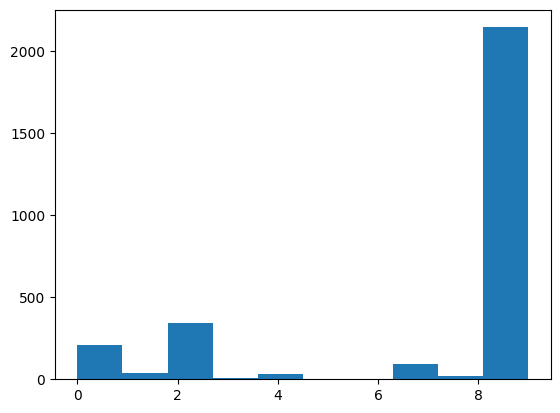

In [86]:
import matplotlib.pyplot as plt
plt.hist(primary.url_prediction)

(array([408.,  10., 515.,  24., 318., 232.,   1., 171.,  50., 381.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

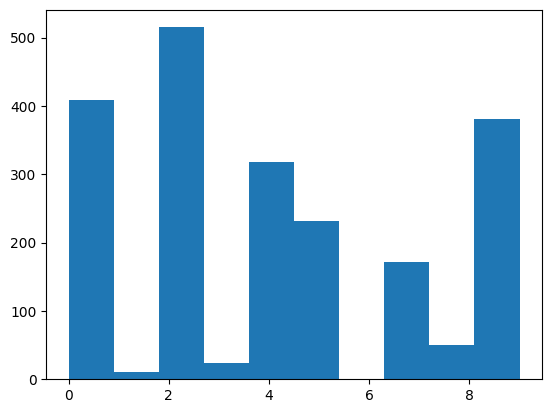

In [87]:
plt.hist(damaged.url_prediction)